<center><h1><b>Stochastic, Batch, & Mini Batch Gradient Descent</b></h1></center>

Batch Gradient Descent uses all taining samples for one forward pass and then adjust weights and bais. This is good for trainig set or training data.

Stochastic Gradiet Descent uses one randomly pcked sample for a forward pass and then adjust weights . This is good when training set is very big with limited computation.

Mini batch is like sichastic. instead of choosing one randomly picked traiig sample, a batch of randomly picked training samples are used and then adjust weights.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/homeprices-banglore/homeprices_banglore.csv


In [30]:
import numpy as np
import pandas as pd
import random
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  # for scaling the dataset

%matplotlib inline

In [3]:
data = pd.read_csv('/kaggle/input/homeprices-banglore/homeprices_banglore.csv')

In [4]:
data.head()

,area,bedrooms,price
0,1056,2,39.07
1,2600,4,120.00
2,1440,3,62.00
3,1521,3,75.00
4,1200,2,51.00


In [5]:
data.shape

(20, 3)

## Scaling of the dataset

In [6]:
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(data.drop('price', axis = 1))
scaled_X

array([[0.08827586, 0.25      ],
       [0.62068966, 0.75      ],
       [0.22068966, 0.5       ],
       [0.24862069, 0.5       ],
       [0.13793103, 0.25      ],
       [0.12758621, 0.25      ],
       [0.6662069 , 0.75      ],
       [0.86206897, 0.75      ],
       [0.17586207, 0.5       ],
       [1.        , 1.        ],
       [0.34482759, 0.5       ],
       [0.68448276, 0.75      ],
       [0.06896552, 0.25      ],
       [0.10344828, 0.25      ],
       [0.5       , 0.5       ],
       [0.12931034, 0.25      ],
       [0.13103448, 0.5       ],
       [0.25517241, 0.5       ],
       [0.67931034, 0.5       ],
       [0.        , 0.        ]])

In [7]:
scaled_y = sy.fit_transform(data['price'].values.reshape(data.shape[0], 1))
scaled_y

array([[0.05237037],
       [0.65185185],
       [0.22222222],
       [0.31851852],
       [0.14074074],
       [0.04444444],
       [0.76296296],
       [0.91111111],
       [0.13333333],
       [1.        ],
       [0.37037037],
       [0.8       ],
       [0.04444444],
       [0.05925926],
       [0.51111111],
       [0.07407407],
       [0.11851852],
       [0.20740741],
       [0.51851852],
       [0.        ]])

## Batch Gradient Descent

In [18]:
# Batch Gradient Descent Function
def batch_gradient_descent(X, y_true, epochs, learning_rate = 0.01):
    number_of_features = X.shape[1]
    
    w = np.ones(shape = (number_of_features))  # weight1 and weight2 values will be 1 each
    b = 0
    total_samples = X.shape[0]
    
    cost_list = []
    epoch_list = []
    for i in range(epochs):        
        y_predicted = np.dot(w, scaled_X.T) + b  # w1 * area + w2 * bedrooms + bias
        
        w_grad = -(2/total_samples) * (X.T.dot(y_true - y_predicted))
        b_grad = -(2/total_samples)* np.sum(y_true - y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.mean(np.square(y_true - y_predicted))
        
        if i % 10 == 0:
            cost_list.append(cost)
            epoch_list.append(i)
            
    return w, b, cost, cost_list, epoch_list

In [20]:
w, b, cost, cost_list, epoch_list = batch_gradient_descent(scaled_X, scaled_y.reshape(scaled_y.shape[0],), 500)
w, b, cost

(array([0.70712464, 0.67456527]), -0.23034857438407427, 0.0068641890429808105)

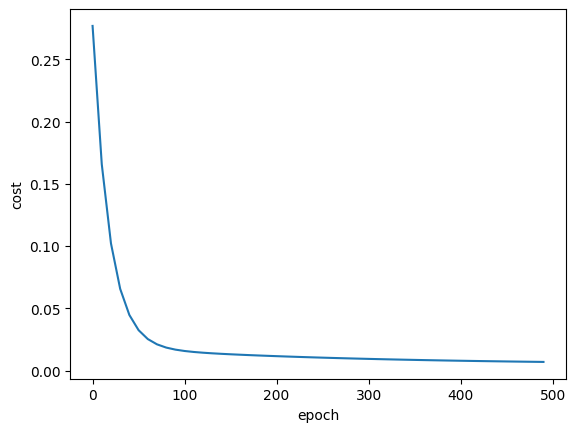

In [21]:
plt.xlabel('epoch')
plt.ylabel('cost')
plt.plot(epoch_list, cost_list);

In [24]:
def predict(area, bedrooms, w, b):
    scaled_X = sx.transform([[area, bedrooms]])[0]
    
    scaled_price = w[0] * scaled_X[0] + w[1] * scaled_X[1] + b
    return sy.inverse_transform([[scaled_price]])[0][0]

In [25]:
predict(2600, 4, w, b)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


128.45484403267596

In [26]:
predict(1000, 2, w, b)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


30.253094462442355

In [27]:
predict(1500, 3, w, b)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


69.47860785714694

 ## Stochastic Gradient Descent

In [28]:
def stochastic_gradient_descent(X, y_true, epochs, learning_rate = 0.01):
    number_of_features = X.shape[1]
    w = np.ones(shape = (number_of_features))
    b = 0
    total_samples = X.shape[0]
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):
        random_index = random.randint(0, total_samples - 1)  # random.randint will randomly pick a number from the range given
        sample_x = X[random_index]
        sample_y = y_true[random_index]
        
        y_predicted = np.dot(w, sample_x.T) + b
        
        w_grad = -(2/total_samples) * (sample_x.T.dot(sample_y - y_predicted))
        b_grad = -(2/total_samples) * (sample_y - y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.square(sample_y - y_predicted)
        
        if i % 100 == 0:  # at every 100th iteration record the cost and epoch value

            cost_list.append(cost)
            epoch_list.append(i)
    
    return w, b, cost, cost_list, epoch_list

In [31]:
w_sgd, b_sgd, cost_sgd, cost_list_sgd, epoch_list_sgd = stochastic_gradient_descent(scaled_X, scaled_y.reshape(scaled_y.shape[0],), 10000)
w_sgd, b_sgd, cost_sgd

(array([0.70670272, 0.6703905 ]), -0.228127462954726, 0.0017383431606789903)

In [32]:
w, b, cost

(array([0.70712464, 0.67456527]), -0.23034857438407427, 0.0068641890429808105)

### Stochastic Gradient Descent Epoch Visualization

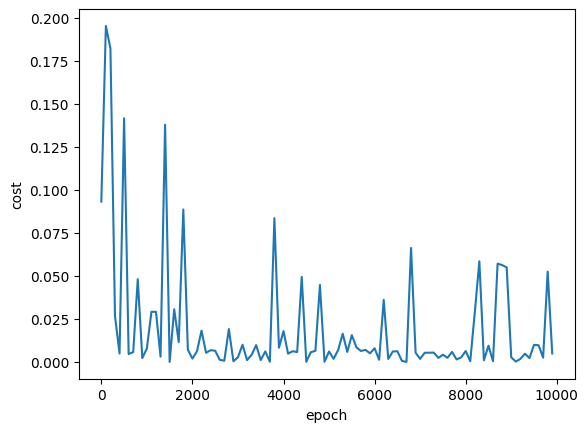

In [33]:
plt.xlabel('epoch')
plt.ylabel('cost')
plt.plot(epoch_list_sgd, cost_list_sgd);

In [34]:
predict(2600, 4, w_sgd, b_sgd)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


128.29664448258163

## Mini Batch Gradient

Implement mini batch gradient dscent in python and plot cost vs epoch graph. mini batch is an intermediate version of batch gradient descent and stochastic gradient descent. Mini batch is where m is batch size and it is 0 < m < n, where n is total number of samples

In [38]:
# Mini-batch gradient descent function
def mini_batch_gradient_descent(X, y_true, epochs, batch_size, learning_rate=0.01):
    number_of_features = X.shape[1]
    total_samples = X.shape[0]
    
    w = np.ones(shape=(number_of_features))  # Initialize weights
    b = 0  # Initialize bias

    cost_list = []
    epoch_list = []
 
    for i in range(epochs):
        # Shuffle the dataset before creating batches
        indices = np.random.permutation(total_samples)
        X_shuffled = X[indices]
        y_shuffled = y_true[indices]

        # Mini-batch iteration
        for j in range(0, total_samples, batch_size):
            X_batch = X_shuffled[j:j+batch_size]
            y_batch = y_shuffled[j:j+batch_size]

            # Predictions for the batch
            y_predicted = np.dot(X_batch, w) + b
            
            # Gradients
            w_grad = -(2 / batch_size) * np.dot(X_batch.T, (y_batch - y_predicted))
            b_grad = -(2 / batch_size) * np.sum(y_batch - y_predicted)
            
            # Update weights and bias
            w = w - learning_rate * w_grad
            b = b - learning_rate * b_grad
        
        # Compute cost (mean squared error) for the entire dataset
        y_predicted_full = np.dot(X, w) + b
        cost = np.mean(np.square(y_true - y_predicted_full))

        if i % 10 == 0:  # Record cost every 10 epochs
            cost_list.append(cost)
            epoch_list.append(i)
            print(f"Epoch {i}: Cost = {cost}")
    
    return w, b, cost, cost_list, epoch_list

In [39]:
batch_size = 5

In [40]:
# Running mini-batch gradient descent
w_mini, b_mini, cost_mini, cost_list_mini, epoch_list_mini = mini_batch_gradient_descent(scaled_X, scaled_y.reshape(scaled_y.shape[0],), epochs=500, batch_size=batch_size)


Epoch 0: Cost = 0.22478961061461064
Epoch 10: Cost = 0.038775934314482105
Epoch 20: Cost = 0.01768053345754248
Epoch 30: Cost = 0.014125913344326863
Epoch 40: Cost = 0.012606510672440008
Epoch 50: Cost = 0.0114620548475605
Epoch 60: Cost = 0.010495659308361447
Epoch 70: Cost = 0.009668254642909652
Epoch 80: Cost = 0.008958485886542793
Epoch 90: Cost = 0.008348447385136971
Epoch 100: Cost = 0.007824875358104878
Epoch 110: Cost = 0.007374543448145044
Epoch 120: Cost = 0.006987168068098655
Epoch 130: Cost = 0.00665325323474594
Epoch 140: Cost = 0.006364866777813343
Epoch 150: Cost = 0.0061157364114192625
Epoch 160: Cost = 0.0058999165848995
Epoch 170: Cost = 0.005712880810207891
Epoch 180: Cost = 0.005550273917007219
Epoch 190: Cost = 0.005408507394110045
Epoch 200: Cost = 0.005284645838105109
Epoch 210: Cost = 0.005175992279830848
Epoch 220: Cost = 0.005080445363468696
Epoch 230: Cost = 0.00499612584686196
Epoch 240: Cost = 0.00492146511674193
Epoch 250: Cost = 0.004854900340438135
Epoch

In [41]:
predict(2600, 4, w_mini, b_mini)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


122.88310042302278

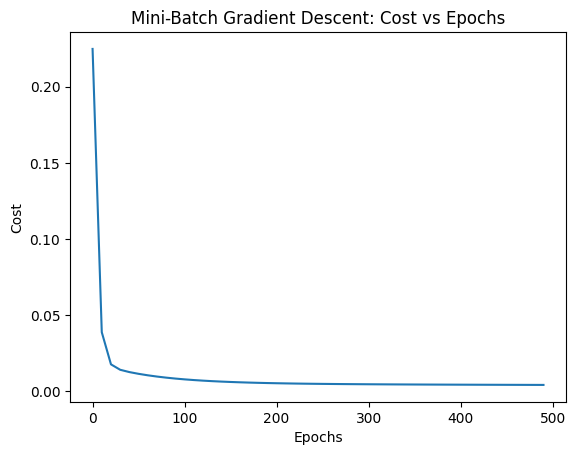

In [42]:
# Plot cost vs epoch graph
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.plot(epoch_list_mini, cost_list_mini)
plt.title('Mini-Batch Gradient Descent: Cost vs Epochs')
plt.show()
